# Classificação de texto com RNN

André Valença, Lucas Valença, Mateus Nascimento

## Setup

In [2]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Selecionando Datasets e Dataframes

In [4]:
testingDatasets = []
trainingDatasets = []

for i in range(2):
  testingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/test/dialogues_00' + str(i+1) + '.json'))

for i in range(9):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_00' + str(i+1) + '.json'))

for i in range(8):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_0' + str(i+10) + '.json'))

testingDatasets = pd.concat([testingDatasets[0], testingDatasets[1]])
trainingDatasets = pd.concat([trainingDatasets[0], trainingDatasets[1],trainingDatasets[2],trainingDatasets[3],trainingDatasets[4],trainingDatasets[5],trainingDatasets[6],trainingDatasets[7],trainingDatasets[8],trainingDatasets[9],trainingDatasets[10],trainingDatasets[11],trainingDatasets[12],trainingDatasets[13],trainingDatasets[14],trainingDatasets[15],trainingDatasets[16]])
testingDatasets

,dialogue_id,services,turns
0,MUL0484.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'train..."
1,PMUL4462.json,"[restaurant, taxi, attraction]","[{'frames': [{'actions': [], 'service': 'resta..."
2,PMUL0320.json,"[restaurant, taxi, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
3,MUL2155.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
4,PMUL0815.json,"[restaurant, train]","[{'frames': [{'actions': [], 'service': 'resta..."
...,...,...,...
483,MUL0306.json,"[restaurant, train]","[{'frames': [{'actions': [], 'service': 'train..."
484,MUL2228.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'train..."
485,MUL0641.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
486,PMUL1194.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'attra..."


In [5]:
trainingDatasets

,dialogue_id,services,turns
0,PMUL4398.json,"[restaurant, hotel]","[{'frames': [{'actions': [], 'service': 'resta..."
1,SNG1013.json,[hotel],"[{'frames': [{'actions': [], 'service': 'hotel..."
2,PMUL0121.json,"[restaurant, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
3,PMUL3484.json,"[restaurant, taxi, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
4,SNG0389.json,[train],"[{'frames': [{'actions': [], 'service': 'train..."
...,...,...,...
241,SNG1123.json,[attraction],"[{'frames': [{'actions': [], 'service': 'attra..."
242,SNG0925.json,[hotel],"[{'frames': [{'actions': [], 'service': 'hotel..."
243,MUL1853.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'train..."
244,WOZ20361.json,[restaurant],"[{'frames': [{'actions': [], 'service': 'resta..."


In [6]:
# seleciona no json os campos relevantes. Apenas as falas dos usuários (ignora os do System)
def getDataframes(dataframe):
  entries_classifier = []
  entries_extractor = []

  for turn in dataframe['turns']:
    for entry in turn:
      if entry['speaker'] == 'USER':
        intent = ''
        slot_values = []
        requested_slots = []
        phrase = entry['utterance']
        for frame in entry['frames']:  
          if frame['state']['active_intent'] != 'NONE':
            intent = frame['state']['active_intent']
            slot_values = frame['state']['slot_values']
            requested_slots = frame['state']['requested_slots']
        entries_classifier.append({'entry': phrase, 'intent': intent})
        entries_extractor.append({'entry': phrase, 'intent': intent, 'slot_values': slot_values, 'requested_slots': requested_slots})

  classifier = pd.DataFrame.from_dict(entries_classifier)
  extractor = pd.DataFrame.from_dict(entries_extractor)

  return classifier, extractor

test_classifier, test_extractor = getDataframes(testingDatasets)
train_classifier, train_extractor = getDataframes(trainingDatasets)

test_classifier

,entry,intent
0,I need train reservations from norwich to camb...,find_train
1,I'd like to leave on Monday and arrive by 18:00.,find_train
2,"Before booking, I would also like to know the ...",find_train
3,No hold off on booking for now. Can you help m...,find_attraction
4,"Yes, that was all I needed. Thank you very much!",
...,...,...
7367,"A swimming pool sounds like much more fun, doe...",find_attraction
7368,Any one of those is fine. May I get the entran...,find_attraction
7369,"Yes. I am also looking for a train, leaving on...",find_train
7370,That will work. Can I have this booking for si...,book_train


In [7]:
trainingDatasets['turns']

0      [{'frames': [{'actions': [], 'service': 'resta...
1      [{'frames': [{'actions': [], 'service': 'hotel...
2      [{'frames': [{'actions': [], 'service': 'hotel...
3      [{'frames': [{'actions': [], 'service': 'hotel...
4      [{'frames': [{'actions': [], 'service': 'train...
                             ...                        
241    [{'frames': [{'actions': [], 'service': 'attra...
242    [{'frames': [{'actions': [], 'service': 'hotel...
243    [{'frames': [{'actions': [], 'service': 'train...
244    [{'frames': [{'actions': [], 'service': 'resta...
245    [{'frames': [{'actions': [], 'service': 'resta...
Name: turns, Length: 8437, dtype: object

## Classificando "intents"


### Remarcando "intents" dos outros domínios

In [8]:
# aqueles intents que não interessam ao projeto são marcados como "Invalid"
def recognizeIntents(intent):
  if (intent == 'find_restaurant' or intent == 'book_restaurant'):
    return intent
  return 'Invalid'

train_classifier['intent'] = train_classifier['intent'].apply(recognizeIntents)
test_classifier['intent'] = test_classifier['intent'].apply(recognizeIntents)
train_extractor['intent'] = train_extractor['intent'].apply(recognizeIntents)
test_extractor['intent'] = test_extractor['intent'].apply(recognizeIntents)

train_classifier = train_classifier[train_classifier['intent']!='Invalid']
test_classifier = test_classifier[test_classifier['intent']!='Invalid']


train_classifier['intent'].unique()


array(['find_restaurant', 'book_restaurant'], dtype=object)

In [9]:
train_classifier['intent'].head(16)

7     find_restaurant
8     find_restaurant
15    find_restaurant
16    find_restaurant
24    find_restaurant
25    find_restaurant
38    find_restaurant
39    book_restaurant
43    find_restaurant
45    find_restaurant
46    find_restaurant
48    book_restaurant
51    find_restaurant
52    find_restaurant
53    find_restaurant
54    find_restaurant
Name: intent, dtype: object

In [10]:
train_classifier['intent'].unique()

array(['find_restaurant', 'book_restaurant'], dtype=object)

### Criando categorias para os "intents"


In [11]:
# transforma as strings categóricas em números, permitindo processar melhor
train_classifier['intent'] = pd.Categorical(train_classifier['intent'])
train_classifier['intent'] = train_classifier.intent.cat.codes
train_classifier['intent'].unique()

array([1, 0], dtype=int8)

In [12]:
test_classifier['intent'] = pd.Categorical(test_classifier['intent'])
test_classifier['intent'] = test_classifier.intent.cat.codes
test_classifier['intent'].unique()

<ipython-input-12-852c684f7d6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_classifier['intent'] = pd.Categorical(test_classifier['intent'])
<ipython-input-12-852c684f7d6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_classifier['intent'] = test_classifier.intent.cat.codes


array([1, 0], dtype=int8)

## Setup input pipeline


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_classifier['entry'], train_classifier['intent']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_classifier['entry'], test_classifier['intent']))
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"No, but I'd really like to be on the south end of the city. Do any of those fit the bill?"
label:  1


In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [15]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
# agora, ele já está com a batch de 64 entradas
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  [b'Any type of food is fine'
 b'I would like a moderately priced restaurant that serves mexican food'
 b'Well how about finding a museum that has an asian oriental restaurant in the expensive price range nearby.'
 b'There will be 4 people attending.'
 b"I'll need a ride there. Can you arrange a taxi for me?"
 b"I'm wondering if you have information about a particular restaurant called the curry queen?"
 b'How about italian?' b'I need a museum in the centre please.'
 b'How about Indian food by itself?'
 b'Yes, please. It should be in the cheap price range.'
 b"Let's try the west." b'yes, please for 8 people at 13:45 on wednesday'
 b'Yes, I am looking forward to trying some local restaurants when I am there. Can you help me find a place to dine?'
 b'Yes please. I would like to book a table for 8 people on Tuesday at 15:00.'
 b'Can you also recommend a moderately-priced restaurant in the centre?'
 b"I'm looking for a restaurant in a moderate price range."
 b'Any type is fine can yo

## Criando o encoder (codificador) de texto

Processando o texto para treinamento usando a layer de `TextVectorization`.

Criando a layer e passando o texto para o método `.adapt`:

In [17]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# pegando nossos textos e criando o vocabulário
encoder.adapt(train_dataset.map(lambda text, label: text))

Primeiros 20 tokens, listados por frequência (exceto o '' e as palavras desconhecidas UKN) 

In [18]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'i', 'a', 'for', 'restaurant', 'in', 'to',
       'you', 'please', 'food', 'and', 'that', 'can', 'of', 'me',
       'looking', 'on', 'need'], dtype='<U16')

Com o vocabulário estabelecido, a layer agora pode fazer o enconding dos texto para os índices. Os tensors têm, todos, o mesmo tamanho (o 0 completa as frases menores).

Abaixo, pegamos os primeiros três de "example", textos extraídos do train_dataset, para servir de exemplo.
Cada palavra recebe um valor numérico, que pode ser reconvertido em palavras.

In [19]:
# como se pode ver, cada número representa uma palavra
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 50, 111,  15,  11,  20, 128,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  3,  23,  22,   4,  78,  70,   6,  13,  45, 266,  11,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [146,  52,  36, 230,   4, 298,  13, 218,  48, 168, 177,   6,   7,
          2,  27,  37,  40, 558,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])

In [20]:
example.numpy()[:3]

array([b'Any type of food is fine',
       b'I would like a moderately priced restaurant that serves mexican food',
       b'Well how about finding a museum that has an asian oriental restaurant in the expensive price range nearby.'],
      dtype=object)

Pontuação e capitalização são perdidas na reconversão.

In [21]:
# em vocab[encoded_example[n]]), passamos o valor numérico
# de cada palavra, que é mapeado em vocab
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Any type of food is fine'
Round-trip:  any type of food is fine                       

Original:  b'I would like a moderately priced restaurant that serves mexican food'
Round-trip:  i would like a moderately priced restaurant that serves mexican food                  

Original:  b'Well how about finding a museum that has an asian oriental restaurant in the expensive price range nearby.'
Round-trip:  well how about finding a museum that has an asian oriental restaurant in the expensive price range nearby           



## Criando o modelo

O modelo para treino. Entram frases com o tamanho padded e, dentro, são transformadas em vetores de tamanho 64. Passa por algumas funções de ativação e vai devolver, na previsão (.predict), um dos intents.

In [69]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-tr

Compile o modelo Keras para configurar o processo de treinamento:

In [70]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=["mae", "acc"]
              )

## Treinando o modelo

In [71]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
188/188 [==============================] - 19s 50ms/step - loss: 0.2432 - mae: 0.5000 - acc: 0.9076 - val_loss: 0.2281 - val_mae: 0.5000 - val_acc: 0.9259
Epoch 2/10
188/188 [==============================] - 6s 31ms/step - loss: 0.1413 - mae: 0.5000 - acc: 0.9532
Epoch 3/10
188/188 [==============================] - 6s 31ms/step - loss: 0.1268 - mae: 0.5000 - acc: 0.9582
Epoch 4/10
188/188 [==============================] - 6s 31ms/step - loss: 0.1182 - mae: 0.5000 - acc: 0.9611
Epoch 5/10
188/188 [==============================] - 6s 31ms/step - loss: 0.1099 - mae: 0.5000 - acc: 0.9634
Epoch 6/10
188/188 [==============================] - 6s 31ms/step - loss: 0.1023 - mae: 0.5000 - acc: 0.9678
Epoch 7/10
188/188 [==============================] - 6s 31ms/step - loss: 0.0952 - mae: 0.5000 - acc: 0.9687
Epoch 8/10
188/188 [==============================] - 6s 31ms/step - loss: 0.0881 - mae: 0.5000 - acc: 0.9695
Epoch 9/10
188/188 [==============================] - 6s 31ms/st

In [72]:
test_loss, test_acc, *catch_other_return = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

21/21 [==============================] - 0s 13ms/step - loss: 0.3251 - mae: 0.5000 - acc: 0.9167
Test Loss: 0.3250598907470703
Test Accuracy: 0.5


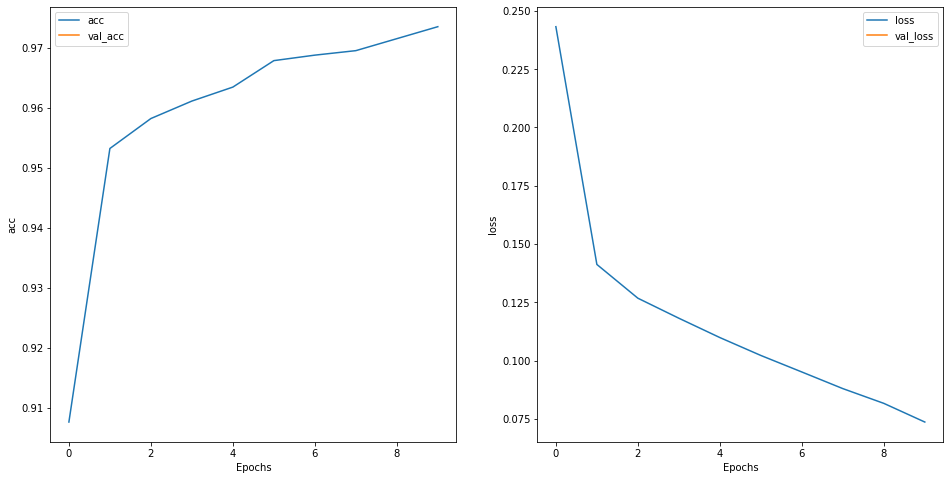

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [85]:
predictions = model.predict(['I want a restaurant on the east part of town where dozens can eat at night'])
c = np.array(['book_restaurant','find_restaurant'])
print(predictions[0])
print(c[np.argmax(predictions[0])])

[8.494512e-04 9.991505e-01]
find_restaurant


# Extrator de entidades


In [13]:
pd.set_option('display.max_colwidth', None) 
train_extractor.head(30)

,entry,intent,slot_values,requested_slots
0,i need a place to dine in the center thats expensive,Invalid,{},[]
1,"Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?",Invalid,{},[]
2,"Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
3,Yes. Can you book it for me?,Invalid,"{'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
4,i want to book it for 2 people and 2 nights starting from saturday.,Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeople': ['2'], 'hotel-bookstay': ['2'], 'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[]
5,"That is all I need to know. Thanks, good bye.",Invalid,[],[]
6,"Guten Tag, I am staying overnight in Cambridge and need a place to sleep. I need free parking and internet.",Invalid,"{'hotel-area': ['centre'], 'hotel-internet': ['yes'], 'hotel-parking': ['yes']}",[]
7,"No, but I'd really like to be on the south end of the city. Do any of those fit the bill?",find_restaurant,{},[]
8,No I don't care about the price. Which one do you recommend?,find_restaurant,{},[]
9,"Yes, book it for 4 people and 4 nights starting from tuesday.",Invalid,"{'hotel-area': ['south'], 'hotel-bookday': ['tuesday'], 'hotel-bookpeople': ['4'], 'hotel-bookstay': ['4'], 'hotel-internet': ['yes'], 'hotel-parking': ['yes']}",[]


In [14]:
# Ver se mantendo as vírgulas e pontos melhora o desempenho
# train_extractor['entry'] = train_extractor['entry'].apply(lambda x: x.lower().replace('.','').replace(',','').replace(':','').replace(';','').replace('!','').replace('?','').replace('\'',''))
train_extractor['entry'] = train_extractor['entry'].apply(lambda x: x.lower().replace('\'','')).replace('2018', '\'').replace('2019', '\'').replace(';', ',').replace('-', ' ').replace("b&b", "bed and breakfast").replace("b and b", "bed and breakfast").replace("dont care", "dontcare")
# train_extractor['entry'] = train_extractor['entry'].apply(lambda x : x.split())

Criando uma coluna que tenha o texto original e, no lugar da palavra que explicita o pedido, uma referência (definida no dataset), e.g. "restaurant-area"

In [15]:
# "restaurant-area",
# "restaurant-bookday",
# "restaurant-bookpeople",
# "restaurant-booktime",
# "restaurant-food",
# "restaurant-name",
# "restaurant-pricerange"

import re
def replace_sv(te):
    tsv = []
    for i, j in zip(te['entry'], te['slot_values']):
        st = i
        num = 0
        for k in j:
            pattern = r'(?<!\[)\b'+j[k][0]+'\\b(?![\w\s]*[\]])'
            st = re.sub( pattern, "["+k+"]", st)
        tsv.append(st)
    return tsv
    
train_extractor['phrase'] = replace_sv(train_extractor)
train_extractor

,entry,intent,slot_values,requested_slots,phrase
0,i need a place to dine in the center thats expensive,Invalid,{},[],i need a place to dine in the center thats expensive
1,"any sort of food would be fine, as long as it is a bit expensive. could i get the phone number for your recommendation?",Invalid,{},[],"any sort of food would be fine, as long as it is a bit expensive. could i get the phone number for your recommendation?"
2,"sounds good, could i get that phone number? also, could you recommend me an expensive hotel?",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],"sounds good, could i get that phone number? also, could you recommend me an [hotel-pricerange] [hotel-type]?"
3,yes. can you book it for me?,Invalid,"{'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],yes. can you book it for me?
4,i want to book it for 2 people and 2 nights starting from saturday.,Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeople': ['2'], 'hotel-bookstay': ['2'], 'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],i want to book it for [hotel-bookpeople] people and [hotel-bookpeople] nights starting from [hotel-bookday].
...,...,...,...,...,...
56771,"hello, i am looking for a cheap restaurant that serves german food.",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[],"hello, i am looking for a [restaurant-pricerange] restaurant that serves [restaurant-food] food."
56772,"yes, how about portuguese food?",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],"yes, how about [restaurant-food] food?"
56773,it doesnt matter.,find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],it doesnt matter.
56774,"i would like the address of nandos restaurant, please.",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-name': ['nandos'], 'restaurant-pricerange': ['cheap']}",[restaurant-address],"i would like the address of [restaurant-name] restaurant, please."


Separando em uma lista de palavras. O regex faz manter a pontuação e os espaços em branco, para melhor processamento.

In [16]:
train_extractor['entry2'] = [re.findall(r'\w+(?:-\w+)+|\s+|\w+', i) for i in train_extractor['phrase']]
train_extractor

,entry,intent,slot_values,requested_slots,phrase,entry2
0,i need a place to dine in the center thats expensive,Invalid,{},[],i need a place to dine in the center thats expensive,"[i, , need, , a, , place, , to, , dine, , in, , the, , center, , thats, , expensive]"
1,"any sort of food would be fine, as long as it is a bit expensive. could i get the phone number for your recommendation?",Invalid,{},[],"any sort of food would be fine, as long as it is a bit expensive. could i get the phone number for your recommendation?","[any, , sort, , of, , food, , would, , be, , fine, , as, , long, , as, , it, , is, , a, , bit, , expensive, , could, , i, , get, , the, , phone, , number, , for, , your, , recommendation]"
2,"sounds good, could i get that phone number? also, could you recommend me an expensive hotel?",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],"sounds good, could i get that phone number? also, could you recommend me an [hotel-pricerange] [hotel-type]?","[sounds, , good, , could, , i, , get, , that, , phone, , number, , also, , could, , you, , recommend, , me, , an, , hotel-pricerange, , hotel-type]"
3,yes. can you book it for me?,Invalid,"{'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],yes. can you book it for me?,"[yes, , can, , you, , book, , it, , for, , me]"
4,i want to book it for 2 people and 2 nights starting from saturday.,Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeople': ['2'], 'hotel-bookstay': ['2'], 'hotel-name': ['university arms hotel'], 'hotel-pricerange': ['expensive'], 'hotel-type': ['hotel']}",[],i want to book it for [hotel-bookpeople] people and [hotel-bookpeople] nights starting from [hotel-bookday].,"[i, , want, , to, , book, , it, , for, , hotel-bookpeople, , people, , and, , hotel-bookpeople, , nights, , starting, , from, , hotel-bookday]"
...,...,...,...,...,...,...
56771,"hello, i am looking for a cheap restaurant that serves german food.",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[],"hello, i am looking for a [restaurant-pricerange] restaurant that serves [restaurant-food] food.","[hello, , i, , am, , looking, , for, , a, , restaurant-pricerange, , restaurant, , that, , serves, , restaurant-food, , food]"
56772,"yes, how about portuguese food?",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],"yes, how about [restaurant-food] food?","[yes, , how, , about, , restaurant-food, , food]"
56773,it doesnt matter.,find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],it doesnt matter.,"[it, , doesnt, , matter]"
56774,"i would like the address of nandos restaurant, please.",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-name': ['nandos'], 'restaurant-pricerange': ['cheap']}",[restaurant-address],"i would like the address of [restaurant-name] restaurant, please.","[i, , would, , like, , the, , address, , of, , restaurant-name, , restaurant, , please]"


Filtrando todos os intents que não são referentes ao nosso objetivo. Mantém-se apenas find_restaurant e book_restaurant

In [17]:
train_extractor = train_extractor[train_extractor['intent']!='Invalid']
test_extractor = test_extractor[test_extractor['intent']!='Invalid']
train_extractor.head(20)

,entry,intent,slot_values,requested_slots,phrase,entry2
7,"no, but id really like to be on the south end of the city. do any of those fit the bill?",find_restaurant,{},[],"no, but id really like to be on the south end of the city. do any of those fit the bill?","[no, , but, , id, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, , do, , any, , of, , those, , fit, , the, , bill]"
8,no i dont care about the price. which one do you recommend?,find_restaurant,{},[],no i dont care about the price. which one do you recommend?,"[no, , i, , dont, , care, , about, , the, , price, , which, , one, , do, , you, , recommend]"
15,"yeah, i need a restaurant in the west and with expensive pricing.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],"yeah, i need a restaurant in the [restaurant-area] and with [restaurant-pricerange] pricing.","[yeah, , i, , need, , a, , restaurant, , in, , the, , restaurant-area, , and, , with, , restaurant-pricerange, , pricing]"
16,"no, i dont have a preference, but i need the phone number and postcode.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]","no, i dont have a preference, but i need the phone number and postcode.","[no, , i, , dont, , have, , a, , preference, , but, , i, , need, , the, , phone, , number, , and, , postcode]"
24,can you actually look up a restaurant for me as well?,find_restaurant,{},[],can you actually look up a restaurant for me as well?,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well]"
25,its a place called don pasquale pizzeria.,find_restaurant,{'restaurant-name': ['don pasquale pizzeria']},[],its a place called [restaurant-name].,"[its, , a, , place, , called, , restaurant-name]"
38,i am looking for a restaurant. i would like something cheap that has chinese food.,find_restaurant,"{'restaurant-food': ['chinese'], 'restaurant-pricerange': ['cheap']}",[],i am looking for a restaurant. i would like something [restaurant-pricerange] that has [restaurant-food] food.,"[i, , am, , looking, , for, , a, , restaurant, , i, , would, , like, , something, , restaurant-pricerange, , that, , has, , restaurant-food, , food]"
39,"yes, could you make a reservation for 1 at 20:00 on saturday?",book_restaurant,"{'restaurant-bookday': ['saturday'], 'restaurant-bookpeople': ['1'], 'restaurant-booktime': ['20:00'], 'restaurant-food': ['chinese'], 'restaurant-name': ['the lucky star'], 'restaurant-pricerange': ['cheap']}",[],"yes, could you make a reservation for [restaurant-bookpeople] at [restaurant-booktime] on [restaurant-bookday]?","[yes, , could, , you, , make, , a, , reservation, , for, , restaurant-bookpeople, , at, , restaurant-booktime, , on, , restaurant-bookday]"
43,saturday leaving cambridge anytime after 20:00 please,find_restaurant,{},[],saturday leaving cambridge anytime after 20:00 please,"[saturday, , leaving, , cambridge, , anytime, , after, , 20, 00, , please]"
45,i am also looking for the riverside brasserie.,find_restaurant,{'restaurant-name': ['riverside brasserie']},[],i am also looking for the [restaurant-name].,"[i, , am, , also, , looking, , for, , the, , restaurant-name]"


In [18]:
train_extractor.head(20)

,entry,intent,slot_values,requested_slots,phrase,entry2
7,"no, but id really like to be on the south end of the city. do any of those fit the bill?",find_restaurant,{},[],"no, but id really like to be on the south end of the city. do any of those fit the bill?","[no, , but, , id, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, , do, , any, , of, , those, , fit, , the, , bill]"
8,no i dont care about the price. which one do you recommend?,find_restaurant,{},[],no i dont care about the price. which one do you recommend?,"[no, , i, , dont, , care, , about, , the, , price, , which, , one, , do, , you, , recommend]"
15,"yeah, i need a restaurant in the west and with expensive pricing.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],"yeah, i need a restaurant in the [restaurant-area] and with [restaurant-pricerange] pricing.","[yeah, , i, , need, , a, , restaurant, , in, , the, , restaurant-area, , and, , with, , restaurant-pricerange, , pricing]"
16,"no, i dont have a preference, but i need the phone number and postcode.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]","no, i dont have a preference, but i need the phone number and postcode.","[no, , i, , dont, , have, , a, , preference, , but, , i, , need, , the, , phone, , number, , and, , postcode]"
24,can you actually look up a restaurant for me as well?,find_restaurant,{},[],can you actually look up a restaurant for me as well?,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well]"
25,its a place called don pasquale pizzeria.,find_restaurant,{'restaurant-name': ['don pasquale pizzeria']},[],its a place called [restaurant-name].,"[its, , a, , place, , called, , restaurant-name]"
38,i am looking for a restaurant. i would like something cheap that has chinese food.,find_restaurant,"{'restaurant-food': ['chinese'], 'restaurant-pricerange': ['cheap']}",[],i am looking for a restaurant. i would like something [restaurant-pricerange] that has [restaurant-food] food.,"[i, , am, , looking, , for, , a, , restaurant, , i, , would, , like, , something, , restaurant-pricerange, , that, , has, , restaurant-food, , food]"
39,"yes, could you make a reservation for 1 at 20:00 on saturday?",book_restaurant,"{'restaurant-bookday': ['saturday'], 'restaurant-bookpeople': ['1'], 'restaurant-booktime': ['20:00'], 'restaurant-food': ['chinese'], 'restaurant-name': ['the lucky star'], 'restaurant-pricerange': ['cheap']}",[],"yes, could you make a reservation for [restaurant-bookpeople] at [restaurant-booktime] on [restaurant-bookday]?","[yes, , could, , you, , make, , a, , reservation, , for, , restaurant-bookpeople, , at, , restaurant-booktime, , on, , restaurant-bookday]"
43,saturday leaving cambridge anytime after 20:00 please,find_restaurant,{},[],saturday leaving cambridge anytime after 20:00 please,"[saturday, , leaving, , cambridge, , anytime, , after, , 20, 00, , please]"
45,i am also looking for the riverside brasserie.,find_restaurant,{'restaurant-name': ['riverside brasserie']},[],i am also looking for the [restaurant-name].,"[i, , am, , also, , looking, , for, , the, , restaurant-name]"


## Pegando slots/Criando tags


Pega os valores da coluna de slots e cria uma nova coluna chamada "tags" na qual os 'O' significam que uma dada palavra da frase não diz respeito a uma informação relevante. Informações como a área onde está o restaurante e o preço ficam na posição correspondente das suas palavras na frase.

In [19]:
def get_slots(te):

  tags = []

  for i, row in te.iterrows():
    t = []
    if row['slot_values']:
        for w in row['entry2']:
            ap = 'O'
            for j in row['slot_values']:
                if w == j:
                    ap = w
            t.append(ap)
    else:
        t = ['0' for e in row['entry2']]     
    tags.append(t)
  return tags

train_extractor['tags'] = get_slots(train_extractor)
# get_slots(train_extractor)

<ipython-input-19-a47760cbc476>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_extractor['tags'] = get_slots(train_extractor)


In [20]:
train_extractor.head(50)

,entry,intent,slot_values,requested_slots,phrase,entry2,tags
7,"no, but id really like to be on the south end of the city. do any of those fit the bill?",find_restaurant,{},[],"no, but id really like to be on the south end of the city. do any of those fit the bill?","[no, , but, , id, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, , do, , any, , of, , those, , fit, , the, , bill]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,no i dont care about the price. which one do you recommend?,find_restaurant,{},[],no i dont care about the price. which one do you recommend?,"[no, , i, , dont, , care, , about, , the, , price, , which, , one, , do, , you, , recommend]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15,"yeah, i need a restaurant in the west and with expensive pricing.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],"yeah, i need a restaurant in the [restaurant-area] and with [restaurant-pricerange] pricing.","[yeah, , i, , need, , a, , restaurant, , in, , the, , restaurant-area, , and, , with, , restaurant-pricerange, , pricing]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-area, O, O, O, O, O, restaurant-pricerange, O, O]"
16,"no, i dont have a preference, but i need the phone number and postcode.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]","no, i dont have a preference, but i need the phone number and postcode.","[no, , i, , dont, , have, , a, , preference, , but, , i, , need, , the, , phone, , number, , and, , postcode]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
24,can you actually look up a restaurant for me as well?,find_restaurant,{},[],can you actually look up a restaurant for me as well?,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
25,its a place called don pasquale pizzeria.,find_restaurant,{'restaurant-name': ['don pasquale pizzeria']},[],its a place called [restaurant-name].,"[its, , a, , place, , called, , restaurant-name]","[O, O, O, O, O, O, O, O, restaurant-name]"
38,i am looking for a restaurant. i would like something cheap that has chinese food.,find_restaurant,"{'restaurant-food': ['chinese'], 'restaurant-pricerange': ['cheap']}",[],i am looking for a restaurant. i would like something [restaurant-pricerange] that has [restaurant-food] food.,"[i, , am, , looking, , for, , a, , restaurant, , i, , would, , like, , something, , restaurant-pricerange, , that, , has, , restaurant-food, , food]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-pricerange, O, O, O, O, O, restaurant-food, O, O]"
39,"yes, could you make a reservation for 1 at 20:00 on saturday?",book_restaurant,"{'restaurant-bookday': ['saturday'], 'restaurant-bookpeople': ['1'], 'restaurant-booktime': ['20:00'], 'restaurant-food': ['chinese'], 'restaurant-name': ['the lucky star'], 'restaurant-pricerange': ['cheap']}",[],"yes, could you make a reservation for [restaurant-bookpeople] at [restaurant-booktime] on [restaurant-bookday]?","[yes, , could, , you, , make, , a, , reservation, , for, , restaurant-bookpeople, , at, , restaurant-booktime, , on, , restaurant-bookday]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-bookpeople, O, O, O, restaurant-booktime, O, O, O, restaurant-bookday]"
43,saturday leaving cambridge anytime after 20:00 please,find_restaurant,{},[],saturday leaving cambridge anytime after 20:00 please,"[saturday, , leaving, , cambridge, , anytime, , after, , 20, 00, , please]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
45,i am also looking for the riverside brasserie.,find_restaurant,{'restaurant-name': ['riverside brasserie']},[],i am also looking for the [restaurant-nam

Criando indexes para o vocabulário (no caso, cada char) e as tags. Pela literatura, char-based LSTM (RNN usada para treinar PLN) é mais performático do que word-based. Por isso não fazemos um index por palavra.

In [21]:
rede = []
for a, b in zip(train_extractor['entry2'], train_extractor['tags']):
    rede.append([a, np.array(b)])

labels = []
for index, row in train_extractor.iterrows():
    labels = labels+row['tags']
labels = np.unique(labels)

all_text = " ".join([" ".join(x[0]) for x in rede])
vocab = sorted(set(all_text))

# create character/id and label/id mapping
char2idx = {u:i+1 for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
label2idx = {u:i+1 for i, u in enumerate(labels)}
idx2label = np.array(labels)


print("char2idx")
print(char2idx)

print("idx2char")
print(idx2char)

print("label2idx")
print(label2idx)

print('idx2label')
print(idx2label)

def split_char_labels(eg):
  tokens = eg[0]
  labels=eg[1]

  input_chars = []
  output_char_labels = []

  for token,label in zip(tokens,labels):

    input_chars.extend([char for char in token])
    input_chars.extend(' ')
    output_char_labels.extend([label]*len(token))
    output_char_labels.extend('O')

  return [[char2idx[x] for x in input_chars[:-1]],np.array([label2idx[x] for x in output_char_labels[:-1]])]

data_formatted = [split_char_labels(eg) for eg in rede]

char2idx
{' ': 1, '-': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35, 'x': 36, 'y': 37, 'z': 38}
idx2char
[' ' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z']
label2idx
{'0': 1, 'O': 2, 'restaurant-area': 3, 'restaurant-bookday': 4, 'restaurant-bookpeople': 5, 'restaurant-booktime': 6, 'restaurant-food': 7, 'restaurant-name': 8, 'restaurant-pricerange': 9}
idx2label
['0' 'O' 'restaurant-area' 'restaurant-bookday' 'restaurant-bookpeople'
 'restaurant-booktime' 'restaurant-food' 'restaurant-name'
 'restaurant-pricerange']


Abaixo, uma versão antiga em que fizemos indexação por palavra

In [ ]:
# from itertools import chain

# def get_dict_map(data):
#     tok2idx = {}
#     idx2tok = {}
    
#     vocabulary = []
#     for i in data:
#         vocabulary += i
    
#     vocabulary = set(vocabulary)
    
#     tok2idx = {tok:idx for idx, tok in enumerate(vocabulary)}
#     idx2tok = {idx:tok for idx, tok in enumerate(vocabulary)}
    
#     return tok2idx, idx2tok

# token2idx, idx2token = get_dict_map(train_extractor['entry'])
# tag2idx, idx2tag = get_dict_map(train_extractor['tags'])

## Treinando o modelo

Com os dados de tags e entradas na variável data_formatted, a gente faz o train-test split. Ou seja, separamos uma parte para treinar a máquina e outra para testar sua performance. Como os dados de train_extractor são bem grandes, pegamos o excerto para teste dele mesmo, ao invés de pegar do test_extractor.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, valid_test_data = train_test_split(data_formatted,test_size=0.30, random_state=42)
valid_data, test_data = train_test_split(valid_test_data,test_size=0.50, random_state=42)

O generator basicamente trata os dados para serem inseridos no treinamento (padding etc.) 



In [ ]:
# training generator
def gen_train_series():

    for eg in train_data:
      yield eg[0],eg[1]

# validation generator
def gen_valid_series():

    for eg in valid_data:
      yield eg[0],eg[1]

# test generator
def gen_test_series():

  for eg in test_data:
      yield eg[0],eg[1]
  
# create Dataset objects for train, test and validation sets  
series = tf.data.Dataset.from_generator(gen_train_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_valid = tf.data.Dataset.from_generator(gen_valid_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_test = tf.data.Dataset.from_generator(gen_test_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))

BATCH_SIZE = 128
BUFFER_SIZE=1000

# create padded batch series objects for train, test and validation sets
ds_series_batch = series.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_valid = series_valid.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_test = series_test.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)

# print example batches
for input_example_batch, target_example_batch in ds_series_batch_valid.take(1):
  print(input_example_batch)
  print(target_example_batch)

tf.Tensor(
[[21 25  1 ...  0  0  0]
 [26 27  1 ...  0  0  0]
 [21 25  1 ...  0  0  0]
 ...
 [37 17 31 ...  0  0  0]
 [19 21 34 ...  0  0  0]
 [21  1  1 ...  0  0  0]], shape=(128, 189), dtype=int32)
tf.Tensor(
[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]], shape=(128, 189), dtype=int32)


## Criando o modelo

In [ ]:
vocab_size = len(vocab)+1

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

label_size = len(labels)  

# build LSTM model
def build_model(vocab_size,label_size, embedding_dim, rnn_units, batch_size):
      model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[batch_size, None],mask_zero=True),
          tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
          tf.keras.layers.Dense(label_size)
          ])
      return model

model = build_model(
      vocab_size = len(vocab)+1,
      label_size=len(labels)+1,
      embedding_dim=embedding_dim,
      rnn_units=rnn_units,
      batch_size=BATCH_SIZE)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (128, None, 256)          9984      
                                                                 
 lstm_1 (LSTM)               (128, None, 1024)         5246976   
                                                                 
 dense_2 (Dense)             (128, None, 10)           10250     
                                                                 
Total params: 5,267,210
Trainable params: 5,267,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(vocab_size, label_size)

39 9


In [ ]:
import os

# define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss,metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
history = model.fit(ds_series_batch, epochs=10, validation_data=ds_series_batch_valid,callbacks=[checkpoint_callback])

Epoch 1/10
65/65 [==============================] - 35s 471ms/step - loss: 0.4141 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.3288 - val_sparse_categorical_accuracy: 0.7597
Epoch 2/10
65/65 [==============================] - 29s 441ms/step - loss: 0.2719 - sparse_categorical_accuracy: 0.7823 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.8063
Epoch 3/10
65/65 [==============================] - 29s 441ms/step - loss: 0.2151 - sparse_categorical_accuracy: 0.8188 - val_loss: 0.2036 - val_sparse_categorical_accuracy: 0.8309
Epoch 4/10
65/65 [==============================] - 29s 443ms/step - loss: 0.1830 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.1733 - val_sparse_categorical_accuracy: 0.8567
Epoch 5/10
65/65 [==============================] - 29s 441ms/step - loss: 0.1583 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.1606 - val_sparse_categorical_accuracy: 0.8670
Epoch 6/10
65/65 [==============================] - 29s 442ms/step - loss: 0.1499 - sparse_cate

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = np.array([])
y_trues= np.array([])

# iterate through test set, make predictions based on trained model
for input_example_batch, target_example_batch in ds_series_batch_test:

  pred=model.predict_on_batch(input_example_batch)
  pred_max=tf.argmax(tf.nn.softmax(pred),2).numpy().flatten()
  y_true=target_example_batch.numpy().flatten()

  preds=np.concatenate([preds,pred_max])
  y_trues=np.concatenate([y_trues,y_true])

# remove padding from evaluation
remove_padding = [(p,y) for p,y in zip(preds,y_trues) if y!=0]

r_p = [x[0] for x in remove_padding]
r_t = [x[1] for x in remove_padding]

# print confusion matrix and classification report
print(idx2label)
# ['0' 'O' 'restaurant-area' 'restaurant-bookday' 'restaurant-bookpeople'
#  'restaurant-booktime' 'restaurant-food' 'restaurant-name'
#  'restaurant-pricerange']
print(confusion_matrix(r_p,r_t))
print(classification_report(r_p,r_t))

[[  3447   1045      0      0      0      2      8      0      2]
 [  8608 114630    129     43     14     27    914    207    359]
 [     0     33   3990      0      3      0     11     22    498]
 [     0      4      0   2497    114     70      3      0      3]
 [     0     19      0    182   2873    118     10      0      0]
 [     0     30      0     82     97   4047     33     87      1]
 [   169   1589     90    179    119    210   6618    262   1136]
 [     9     37      0      0     15      0      3    973      1]
 [    11     85    141      5     20     48    260     69   3796]]
              precision    recall  f1-score   support

         1.0       0.28      0.77      0.41      4504
         2.0       0.98      0.92      0.95    124931
         3.0       0.92      0.88      0.90      4557
         4.0       0.84      0.93      0.88      2691
         5.0       0.88      0.90      0.89      3202
         6.0       0.89      0.92      0.91      4377
         7.0       0.84   

In [22]:
train_extractor

,entry,intent,slot_values,requested_slots,phrase,entry2,tags
7,"no, but id really like to be on the south end of the city. do any of those fit the bill?",find_restaurant,{},[],"no, but id really like to be on the south end of the city. do any of those fit the bill?","[no, , but, , id, , really, , like, , to, , be, , on, , the, , south, , end, , of, , the, , city, , do, , any, , of, , those, , fit, , the, , bill]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,no i dont care about the price. which one do you recommend?,find_restaurant,{},[],no i dont care about the price. which one do you recommend?,"[no, , i, , dont, , care, , about, , the, , price, , which, , one, , do, , you, , recommend]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15,"yeah, i need a restaurant in the west and with expensive pricing.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],"yeah, i need a restaurant in the [restaurant-area] and with [restaurant-pricerange] pricing.","[yeah, , i, , need, , a, , restaurant, , in, , the, , restaurant-area, , and, , with, , restaurant-pricerange, , pricing]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, restaurant-area, O, O, O, O, O, restaurant-pricerange, O, O]"
16,"no, i dont have a preference, but i need the phone number and postcode.",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]","no, i dont have a preference, but i need the phone number and postcode.","[no, , i, , dont, , have, , a, , preference, , but, , i, , need, , the, , phone, , number, , and, , postcode]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
24,can you actually look up a restaurant for me as well?,find_restaurant,{},[],can you actually look up a restaurant for me as well?,"[can, , you, , actually, , look, , up, , a, , restaurant, , for, , me, , as, , well]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
56769,what is there phone number?,find_restaurant,"{'restaurant-area': ['east'], 'restaurant-food': ['indian'], 'restaurant-name': ['pipasha restaurant'], 'restaurant-pricerange': ['expensive']}",[restaurant-phone],what is there phone number?,"[what, , is, , there, , phone, , number]","[O, O, O, O, O, O, O, O, O]"
56771,"hello, i am looking for a cheap restaurant that serves german food.",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pricerange': ['cheap']}",[],"hello, i am looking for a [restaurant-pricerange] restaurant that serves [restaurant-food] food.","[hello, , i, , am, , looking, , for, , a, , restaurant-pricerange, , restaurant, , that, , serves, , restaurant-food, , food]","[O, O, O, O, O, O, O, O, O, O, O, O, restaurant-pricerange, O, O, O, O, O, O, O, restaurant-food, O, O]"
56772,"yes, how about portuguese food?",find_restaurant,"{'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],"yes, how about [restaurant-food] food?","[yes, , how, , about, , restaurant-food, , food]","[O, O, O, O, O, O, restaurant-food, O, O]"
56773,it doesnt matter.,find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-food': ['portuguese'], 'restaurant-pricerange': ['cheap']}",[],it doesnt matter.,"[it, , doesnt, , matter]","[O, O, O, O, O]"


In [117]:
def replace_sv_rasa(te):
    find = []
    book = []
    for i, j, k in zip(te['entry'].apply(lambda x: x.replace('.', ' .').replace('?', ' ?').replace('!', ' !')), te['slot_values'], te['intent']):
        t = i
        if j:
            t = i
            for w in j:
                t = t.replace(j[w][0], '['+j[w][0]+']{"entity": "'+w+'", "value": "'+j[w][0]+'"}')
        
        if k == 'find_restaurant':
            find.append(t)
        else:
            book.append(t)
    
    return find, book

    
rasa_find,rasa_book = replace_sv_rasa(train_extractor)
train_extractor.head()
rasa_find

['yes, could you make a reservation for [1]{"entity": "restaurant-bookpeople", "value": "1"} at [20:00]{"entity": "restaurant-booktime", "value": "20:00"} on [saturday]{"entity": "restaurant-bookday", "value": "saturday"} ?',
 '[6]{"entity": "restaurant-bookpeople", "value": "6"} people will be dining',
 'i would like to book a table at the [backstreet bistro]{"entity": "restaurant-name", "value": "backstreet bistro"} for [5]{"entity": "restaurant-bookpeople", "value": "5"} people at [16:00]{"entity": "restaurant-booktime", "value": "16:00"} on [thursday]{"entity": "restaurant-bookday", "value": "thursday"} .',
 'yes please make a booking for [8]{"entity": "restaurant-bookpeople", "value": "8"} people at [12:30]{"entity": "restaurant-booktime", "value": "12:30"} on [friday]{"entity": "restaurant-bookday", "value": "friday"} .',
 'please book a table for [4]{"entity": "restaurant-bookpeople", "value": "4"} at the [chinese]{"entity": "restaurant-food", "value": "chinese"} place at [12:30

In [120]:
intents_and_examples = {}
intents_and_examples['find_restaurant'] = rasa_find
intents_and_examples['book_restaurant'] = rasa_book

intents_and_examples

f = open("nlu.yml", "w") 
f.write("nlu:\n") 
for pInt, lista in intents_and_examples.items(): 
    f.write(f'- intent: {pInt}\n') 
    f.write("  examples: |\n") 
    f.writelines([f'    - {phrase}\n' for phrase in lista]) 
    f.write('\n') 
 
f.close()